In [1]:
import xmltodict

In [2]:
!ls

AnalyseAppleWatch.R       SweVAD                    apple_health_export_A_tp2
DataMerge.ipynb           appleWatchExample.zip     exportAC67.zip
NIHP                      apple_health_export       heartrate.csv
Pancreas                  apple_health_export 2


In [3]:
!ls apple_health_export\ 2

electrocardiograms export.xml         export_cda.xml


In [4]:
items = xmltodict.parse(open("apple_health_export 2/export.xml", "rb"))

In [5]:
len(items)

1

In [6]:
items.keys()

odict_keys(['HealthData'])

In [7]:
len(items["HealthData"])

6

In [8]:
items["HealthData"].keys()

odict_keys(['@locale', 'ExportDate', 'Me', 'Record', 'Workout', 'ActivitySummary'])

In [9]:
from IPython.display import JSON

In [10]:
len(items["HealthData"]["Record"])

424490

In [11]:
keys = set()
for record in items["HealthData"]["Record"]:
    keys.add(record["@type"])

In [12]:
keys

{'HKCategoryTypeIdentifierAppleStandHour',
 'HKQuantityTypeIdentifierActiveEnergyBurned',
 'HKQuantityTypeIdentifierAppleExerciseTime',
 'HKQuantityTypeIdentifierAppleStandTime',
 'HKQuantityTypeIdentifierBasalEnergyBurned',
 'HKQuantityTypeIdentifierBodyMass',
 'HKQuantityTypeIdentifierDistanceWalkingRunning',
 'HKQuantityTypeIdentifierFlightsClimbed',
 'HKQuantityTypeIdentifierHeartRate',
 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
 'HKQuantityTypeIdentifierHeight',
 'HKQuantityTypeIdentifierRestingHeartRate',
 'HKQuantityTypeIdentifierSixMinuteWalkTestDistance',
 'HKQuantityTypeIdentifierStairAscentSpeed',
 'HKQuantityTypeIdentifierStairDescentSpeed',
 'HKQuantityTypeIdentifierStepCount',
 'HKQuantityTypeIdentifierVO2Max',
 'HKQuantityTypeIdentifierWalkingAsymmetryPercentage',
 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
 'HKQuantityTypeIdentifierWalkingHeartRateAverage',
 'HKQuantityTypeIdentifierWalkingSpeed',
 'HKQuantityTypeIdentifierWalkingStepLength'}

In [13]:
import pandas as pd

In [18]:
def toSeries(records, typedef, column, merge="mean", gran="D"):
    heartRateSeries = list(filter(lambda t: t["@type"] == typedef, records))
    d = pd.DataFrame(list(map(lambda d: (d["@startDate"], float(d["@value"])), heartRateSeries)), columns=["timestamp", column])
    d["timestamp"] = pd.to_datetime(d["timestamp"], infer_datetime_format=True)
    d.set_index(pd.DatetimeIndex(d['timestamp']))
    
    if merge == "sum":
        rs = d.resample(gran, on="timestamp").sum()
    else:        
        rs = d.resample(gran, on="timestamp").mean()
    return rs

In [23]:
gran = "60min" # gran = "D"
d1 = toSeries(items["HealthData"]["Record"], "HKQuantityTypeIdentifierHeartRate", "heartRate", gran=gran)
d2 = toSeries(items["HealthData"]["Record"], "HKQuantityTypeIdentifierActiveEnergyBurned", "activeEnergyBurned", gran=gran)
d3 = toSeries(items["HealthData"]["Record"], "HKQuantityTypeIdentifierFlightsClimbed", "climbed", merge="sum", gran=gran)

In [24]:
def mergeByTimestamp(dfs):
    if len(dfs) == 0:
        raise ValueError("Empty!")
        
    if len(dfs) == 1:
        return dfs[0]
    
    if len(dfs) >= 2:
        current = dfs[0]
        for i in range(1,len(dfs)):
            current = pd.merge_ordered(current, dfs[i], on="timestamp")
        
        return current

In [27]:
df = mergeByTimestamp([d1, d2, d3])
df

,timestamp,heartRate,activeEnergyBurned,climbed
0,2020-11-27 11:00:00+01:00,NaN,0.097000,NaN
1,2020-11-27 12:00:00+01:00,71.000000,0.076500,NaN
2,2020-11-27 13:00:00+01:00,NaN,NaN,NaN
3,2020-11-27 14:00:00+01:00,NaN,NaN,NaN
4,2020-11-27 15:00:00+01:00,NaN,NaN,NaN
...,...,...,...,...
8304,2021-11-08 11:00:00+01:00,66.750000,0.407698,0.0
8305,2021-11-08 12:00:00+01:00,69.333333,0.483846,0.0
8306,2021-11-08 13:00:00+01:00,79.571429,0.556700,1.0
8307,2021-11-08 14:00:00+01:00,81.896552,0.652333,1.0


<AxesSubplot:>

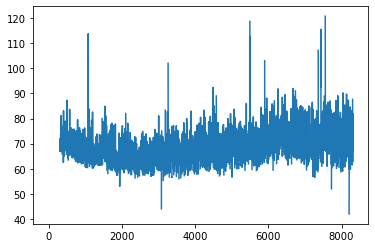

In [28]:
df["heartRate"].plot()